<a href="https://colab.research.google.com/github/LeehyeongTea/image_captioning_with_attention/blob/main/evalutation_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Greedy
BLEU-1: 0.30657606817920074
BLEU-2: 0.18721245800902916
BLEU-3: 0.14069048156256153
BLEU-4: 0.06732569837665317
inference
96116736/96112376 [==============================] - 1s 0us/step


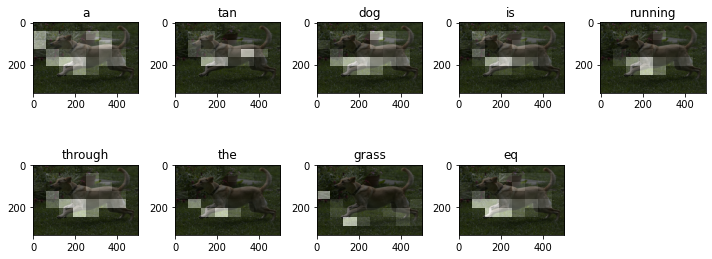

['a', 'tan', 'dog', 'is', 'running', 'through', 'the', 'grass', 'eq']


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import h5py
import re
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from nltk.translate.bleu_score import corpus_bleu

import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
def visualization_attention(image, result, attention_plot):
  temp = np.array(image)
  fig = plt.figure(figsize = (10,10))
  
  for i in range(0,len(result)):
    att = np.resize(attention_plot[i],(8,8))
    grid_size = max(np.ceil(len(result)/2),2)
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.set_title(result[i])
    img = ax.imshow(temp)
    ax.imshow(att, cmap='gray',alpha=0.6,extent=img.get_extent())

  plt.tight_layout()
  plt.show()




def create_caption_greedy(encder,decoder,image,max_len,tokenizer):
  attention_plot = np.zeros((max_len,64))
  hidden = tf.zeros((1, 512))
  
  img = encoder(image)

  text_input = tf.expand_dims([tokenizer.word_index['sq']],0)
  result = []
  for i in range(max_len):
    output,hidden, attention_dist = decoder([text_input,img,hidden])
    attention_plot[i] = tf.reshape(attention_dist,(-1, )).numpy()
    pred = np.argmax(output)

    result.append(tokenizer.index_word[pred])
    
    if tokenizer.index_word[pred] == 'eq':
      return result,attention_plot
    text_input = tf.expand_dims([pred],0)

  return result,attention_plot


def Bleu_Score_greedy(encoder,decoder, seq,sortedList, feature, tokenizer,saved_path, max_len):
  y = list()
  pred = list()

  for elem in sortedList:
    f_arr = np.array(feature[elem][:])
    generated,_ = create_caption_greedy(encoder,decoder,f_arr,max_len,tokenizer)
    target_words = [line.split() for line in seq[elem]]
    y.append(target_words)
    pred.append(generated)

  print("Greedy")
  print('BLEU-1: ' + str(corpus_bleu(y,pred,weights=(1.0,0,0,0))))
  print('BLEU-2: ' + str(corpus_bleu(y,pred,weights=(0.5,0.5,0,0))))
  print('BLEU-3: ' + str(corpus_bleu(y,pred,weights=(0.3,0.3,0.3,0))))
  print('BLEU-4: ' + str(corpus_bleu(y,pred,weights=(0.25, 0.25, 0.25, 0.25))))
  


def inference(encoder,decoder, img_path, tokenizer,max_len,test_list,k):
  print("inference")
  get_CNN = InceptionV3()
  CNN_model = Model(inputs=get_CNN.input, outputs=get_CNN.layers[-3].output)

  img_file = os.path.join(img_path,test_list[5])
  loaded_img = Image.open(img_file, 'r')

  temp = loaded_img

  loaded_img = image.load_img(img_file, target_size = (299, 299))
  loaded_img = image.img_to_array(loaded_img)
  loaded_img = preprocess_input(loaded_img)
  loaded_img = np.expand_dims(loaded_img, 0)
  feature = CNN_model.predict(loaded_img)
  feature = tf.reshape(feature, (feature.shape[0],-1,feature.shape[3]))
  result, attention_plot = create_caption_greedy(encoder,decoder,feature,max_len,tokenizer)
  visualization_attention(temp,result,attention_plot)
  print(result)


if __name__ == '__main__':
  
  base_directory = '/content/gdrive/My Drive/Colab Notebooks/image_captioning_with_attention'
  saved_data_path = os.path.join(base_directory,'data')
  saved_model_path = os.path.join(base_directory,'saved_model_merge')
  data_base_directory ='/content'
  img_data_directory = os.path.join(data_base_directory,'flickr8k_dataset','Flicker8k_Dataset')



  saved_path = os.path.join(base_directory, 'data')
  data_h5_paths = os.path.join(saved_data_path, 'needs.hdf5')
  needs = h5py.File(data_h5_paths, 'r')

  test_dataset_list_path = needs['test_code_path'][()]
  
  test_feature_path = needs['test_feature_path'][()]

  test_seq_path_X = needs['test_seq_path'][()]

  
  tokenpath = needs['token_path'][()]
  max_len = needs['max_len'][()]
  vocab_size= needs['vocab_size'][()]
  
  req_token_path = needs['req_token_path'][()]
  req_test_list_path = needs['req_test_list_path'][()]
  req_seq_path = needs['req_seq_path'][()]
  
  encoder_path = os.path.join(saved_model_path,'encoder_model_19_vacc_0.103_vloss_1.179_acc0.114_loss0.936.h5')
  decoder_path = os.path.join(saved_model_path,'decoder_model_19_vacc_0.103_vloss_1.179_acc0.114_loss0.936.h5')

  with open(req_token_path, 'rb') as handle:
    tokenizer = pickle.load(handle)
  with open(req_test_list_path, 'rb') as handle:
    test_list = pickle.load(handle)
  with open(req_seq_path, 'rb') as handle:
    sequence = pickle.load(handle)

  encoder = load_model(encoder_path)
  decoder = load_model(decoder_path)
  
  with h5py.File(test_feature_path,'r') as hf:
    Bleu_Score_greedy(encoder,decoder, sequence, test_list, hf, tokenizer,saved_path, max_len)

  inference(encoder,decoder, img_data_directory, tokenizer,max_len,test_list,3)    